In [1]:
import sys
sys.path.append('/home/waleed/fastjet-install/lib/python3.6/site-packages')

In [2]:
import h5py
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import fastjet as fj
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

In [3]:
# Load files
fn_qcd  = '/home/waleed/Desktop/LHC-Olympics/events_LHCO2020_backgroundMC_Pythia.h5'
fn_sig  = '/home/waleed/Desktop/LHC-Olympics/events_anomalydetection.h5'
fn_data = '/home/waleed/Desktop/LHC-Olympics/events_LHCO2020_BlackBox1.h5' 

In [14]:
def read_file(path='', nevts=5e3):
    f = pd.read_hdf(path,stop=nevts)
    
    # change naming convention of the coulmns
    #old = list(f.columns)
    #new = ['pt','eta','phi']
    #new = [new]*700
    #new = [item for sublist in new for item in sublist]
    #dictionary = dict(zip(old, new))
    #df = f.rename(dictionary, axis=1)
    
    return f

def run(data,n_events=1000):
    
    out  = []
    Jets = []
    
    # Loop over events
    for ievt in range(n_events):

        # Build a list of all particles
        pjs = []
        for i in range(data.shape[1]):
            pj = fj.PseudoJet()
            pj.reset_PtYPhiM(data[ievt,i,0],data[ievt,i,1],data[ievt,i,2],0)
            pjs.append(pj)

        # run jet clustering with AntiKt, R=1.0
        R = 1.0
        jet_def = fj.JetDefinition(fj.antikt_algorithm, R)

        # Save the two leading jets
        jets = jet_def(pjs)
        jets = [j for j in jets if j.pt()>30.]
        Jets.append(jets)
        out.append([jets[0],jets[1]])
                
    return out, Jets

def select_sgn(df=None):
    X, y = df.iloc[:,0:-1], df.iloc[:,-1]
    X['labels']=y
    X = X.loc[X.labels>0.0]
    return X

def preprocess(df=None):
    df = np.array(df)
    hadrons = []
    for item in tqdm(df):
        l = np.array(np.split(item, 700))
        hadrons.append(l)
    
    hadrons = np.array(hadrons)
    return hadrons

In [5]:
qcd  = read_file(fn_qcd)
data = read_file(fn_data)

In [6]:
wpr  = read_file(fn_sig,1e5)

In [7]:
print (qcd.shape, wpr.shape, data.shape)

(5000, 2100) (100000, 2101) (5000, 2100)


In [8]:
wpr = select_sgn(wpr)

In [9]:
wpr = wpr.iloc[:,0:-1]

In [19]:
wpr.shape

(9059, 700, 3)

In [10]:
qcd = preprocess(qcd)

100%|██████████| 5000/5000 [00:05<00:00, 961.35it/s]


In [11]:
wpr = preprocess(wpr)

100%|██████████| 9059/9059 [00:09<00:00, 945.67it/s]


In [12]:
data = preprocess(data)

100%|██████████| 5000/5000 [00:05<00:00, 986.60it/s] 


In [15]:
# Actually run
# (this may take a few minutes)
out_qcd, jets_qcd = run(qcd)

In [58]:
out_sig, jets_sig = run(wpr,n_events=1000)

In [17]:
out_data, jets_data = run(data)

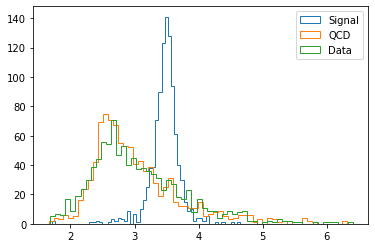

In [59]:
# Extract the leading dijet mass for signal..
dijet_m_sig = []
for evt in out_sig:
    dijet_m_sig.append( (evt[0]+evt[1]).m())

# ..and background
dijet_m_qcd = []
for evt in out_qcd:
    dijet_m_qcd.append( (evt[0]+evt[1]).m())
    
# ..and data
dijet_m_data = []
for evt in out_data:
    dijet_m_data.append( (evt[0]+evt[1]).m())    

# and plot
_ = plt.hist(np.array(dijet_m_sig)*1e-3,label='Signal',bins=60,histtype='step')
_ = plt.hist(np.array(dijet_m_qcd)*1e-3,label='QCD',bins=60,histtype='step')
_ = plt.hist(np.array(dijet_m_data)*1e-3,label='Data',bins=60,histtype='step')

plt.legend(loc='best')

In [23]:
import itertools

In [60]:
Jets_qcd  = list(itertools.chain(*jets_qcd))
Jets_sig  = list(itertools.chain(*jets_sig))
Jets_data = list(itertools.chain(*jets_data))

In [81]:
phi_qcd = []
theta_qcd = []
ene_qcd = []
pt_qcd = []
px_qcd = []
py_qcd = []
pz_qcd = []
eta_qcd = []
rap_qcd = []
mas_qcd = []
prd_qcd = []

phi_sig = []
theta_sig = []
ene_sig = []
pt_sig = []
px_sig = []
py_sig = []
pz_sig = []
eta_sig = []
rap_sig = []
mas_sig = []
prd_sig = []

phi_data = []
theta_data = []
ene_data = []
pt_data = []
px_data = []
py_data = []
pz_data = []
eta_data = []
rap_data = []
mas_data = []
prd_data = []

for jet in tqdm(Jets_qcd):
    phi_qcd.append(jet.phi())
    theta_qcd.append(jet.theta())
    ene_qcd.append(jet.e())
    pt_qcd.append(jet.pt())
    px_qcd.append(jet.px())
    py_qcd.append(jet.py())
    pz_qcd.append(jet.pz())
    eta_qcd.append(jet.eta())
    rap_qcd.append(jet.rapidity())
    mas_qcd.append(jet.m())
    prd_qcd.append(jet.pseudorapidity())
    
    
for jet in tqdm(Jets_sig):
    phi_sig.append(jet.phi())
    theta_sig.append(jet.theta())
    ene_sig.append(jet.e())
    pt_sig.append(jet.pt())
    px_sig.append(jet.px())
    py_sig.append(jet.py())
    pz_sig.append(jet.pz())
    eta_sig.append(jet.eta())
    rap_sig.append(jet.rapidity())
    mas_sig.append(jet.m())
    prd_sig.append(jet.pseudorapidity())
    
    
for jet in tqdm(Jets_data):
    phi_data.append(jet.phi())
    theta_data.append(jet.theta())
    ene_data.append(jet.e())
    pt_data.append(jet.pt())
    px_data.append(jet.px())
    py_data.append(jet.py())
    pz_data.append(jet.pz())
    eta_data.append(jet.eta())
    rap_data.append(jet.rapidity())
    mas_data.append(jet.m())
    prd_data.append(jet.pseudorapidity())

100%|██████████| 3761/3761 [00:00<00:00, 145381.61it/s]


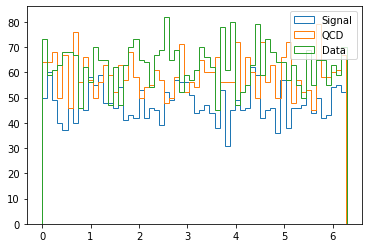

In [62]:
_ = plt.hist(phi_sig,label='Signal',bins=60,histtype='step')
_ = plt.hist(phi_qcd,label='QCD',bins=60,histtype='step')
_ = plt.hist(phi_data,label='Data',bins=60,histtype='step')

plt.legend(loc='best')

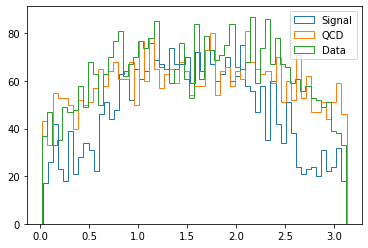

In [63]:
_ = plt.hist(theta_sig,label='Signal',bins=60,histtype='step')
_ = plt.hist(theta_qcd,label='QCD',bins=60,histtype='step')
_ = plt.hist(theta_data,label='Data',bins=60,histtype='step')

plt.legend(loc='best')

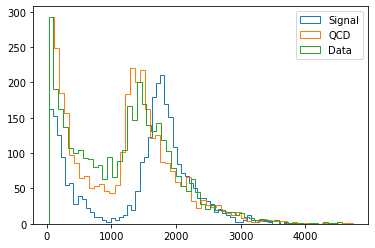

In [64]:
_ = plt.hist(ene_sig,label='Signal',bins=60,histtype='step')
_ = plt.hist(ene_qcd,label='QCD',bins=60,histtype='step')
_ = plt.hist(ene_data,label='Data',bins=60,histtype='step')

plt.legend(loc='best')

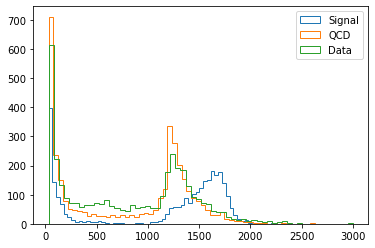

In [65]:
_ = plt.hist(pt_sig,label='Signal',bins=60,histtype='step')
_ = plt.hist(pt_qcd,label='QCD',bins=60,histtype='step')
_ = plt.hist(pt_data,label='Data',bins=60,histtype='step')

plt.legend(loc='best')

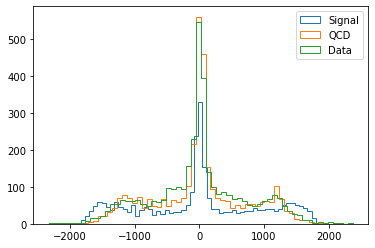

In [66]:
_ = plt.hist(px_sig,label='Signal',bins=60,histtype='step')
_ = plt.hist(px_qcd,label='QCD',bins=60,histtype='step')
_ = plt.hist(px_data,label='Data',bins=60,histtype='step')

plt.legend(loc='best')

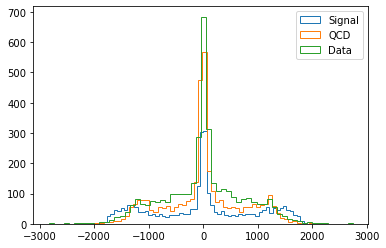

In [67]:
_ = plt.hist(py_sig,label='Signal',bins=60,histtype='step')
_ = plt.hist(py_qcd,label='QCD',bins=60,histtype='step')
_ = plt.hist(py_data,label='Data',bins=60,histtype='step')

plt.legend(loc='best')

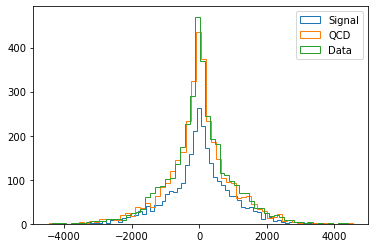

In [68]:
_ = plt.hist(pz_sig,label='Signal',bins=60,histtype='step')
_ = plt.hist(pz_qcd,label='QCD',bins=60,histtype='step')
_ = plt.hist(pz_data,label='Data',bins=60,histtype='step')

plt.legend(loc='best')

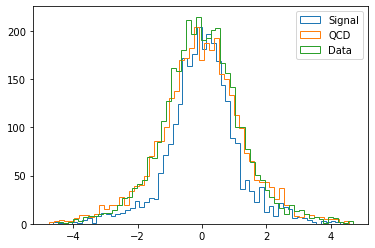

In [69]:
_ = plt.hist(eta_sig,label='Signal',bins=60,histtype='step')
_ = plt.hist(eta_qcd,label='QCD',bins=60,histtype='step')
_ = plt.hist(eta_data,label='Data',bins=60,histtype='step')

plt.legend(loc='best')

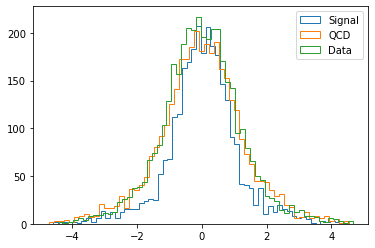

In [70]:
_ = plt.hist(rap_sig,label='Signal',bins=60,histtype='step')
_ = plt.hist(rap_qcd,label='QCD',bins=60,histtype='step')
_ = plt.hist(rap_data,label='Data',bins=60,histtype='step')

plt.legend(loc='best')

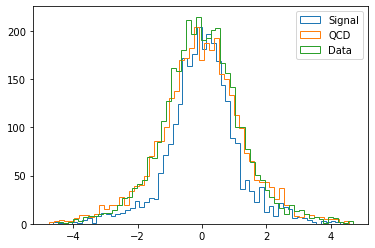

In [82]:
_ = plt.hist(prd_sig,label='Signal',bins=60,histtype='step')
_ = plt.hist(prd_qcd,label='QCD',bins=60,histtype='step')
_ = plt.hist(prd_data,label='Data',bins=60,histtype='step')

plt.legend(loc='best')

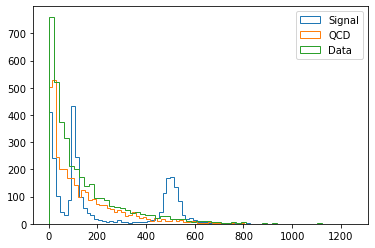

In [74]:
_ = plt.hist(mas_sig,label='Signal',bins=60,histtype='step')
_ = plt.hist(mas_qcd,label='QCD',bins=60,histtype='step')
_ = plt.hist(mas_data,label='Data',bins=60,histtype='step')

plt.legend(loc='best')